# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1455]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.preprocessing import StandardScaler,LabelEncoder 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.model_selection import train_test_split ,cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
import xgboost as xgb
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [932]:
# load in the General Population and Customer Population datasets (unlabled Data)
azdias = pd.read_csv('C:/Users/ruoyu.zhao/Anaconda3/ML/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('C:/Users/ruoyu.zhao/Anaconda3/ML/Udacity_CUSTOMERS_052018.csv', sep=';')
# Load in Attributes default unkown values Mapping sheet (created manually)
unknown_default_values=pd.read_csv('C:/Users/ruoyu.zhao/Anaconda3/ML/atrributes_unkownvalues.csv',sep=',')

C:\Users\ruoyu.zhao\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [933]:
# Convert azdias and customer dataset into dataframes 
General_Population= pd.DataFrame(azdias)
Customer_Population = pd.DataFrame(customers)
# Rename Field Names(only ones that have prefix "_RZ") in the unknown_default_values list
unknown_default_values['Attributes'] = unknown_default_values['Attributes'].str.replace('_RZ', '')

In [937]:
# del azdias
# del customers
del General_Population
del Customer_Population

While loading the data, the error warning message tells us that there are two columns which has mixed data type, therefore we need to have a closer look at these two fields. 

In [585]:
# Identify the names of the two fields with mixed data types
print(General_Population.columns[18])
print(General_Population.columns[19])

# Look at the unique values in both columns
print(General_Population['CAMEO_DEUG_2015'].unique())
print(General_Population['CAMEO_INTL_2015'].unique())

CAMEO_DEUG_2015
CAMEO_INTL_2015
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


Values like 5.0 and '5' should mean the same thing, therefore need to be aligned. We need to provide additional data 
cleasing for those two columns particularly.

In [592]:
def column_values_alignment(data):
    """ Only for CAMEO_DEUG_2015 and CAMEO_INTL_2015 two columns for a dataset
        Convert numeric-like string e.g. '5' into integer 5
        Convert float into integer e.g. 5.0 into 5
        Convert non numeric values such as "XX" and "X" into NaN as this appear to be data issues
    
    Attributes:
        dataset (dataframe) this is the dataset to be processed.  
    
    Output:
        the updated Dataset
    """      
    
    data['CAMEO_INTL_2015'] = pd.to_numeric(data['CAMEO_INTL_2015'],errors='coerce').astype('Int64')
    data['CAMEO_DEUG_2015'] = pd.to_numeric(data['CAMEO_DEUG_2015'],errors='coerce').astype('Int64')

    return data

In [935]:
# Execute column_values_alignment to both General Population and Customer Population Datasets
General_Population = column_values_alignment(General_Population)
Customer_Population = column_values_alignment(Customer_Population)
print(General_Population['CAMEO_DEUG_2015'].unique())
print(General_Population['CAMEO_INTL_2015'].unique())

<IntegerArray>
[NaN, 8, 4, 2, 6, 1, 9, 5, 7, 3]
Length: 10, dtype: Int64
<IntegerArray>
[NaN,  51,  24,  12,  43,  54,  22,  14,  13,  15,  33,  41,  34,  55,  25,
  23,  31,  52,  35,  45,  44,  32]
Length: 22, dtype: Int64


## Convert Default "Unknown" Values into NaN
By observing the data and looking at the attribute information sheets. Unfortunately, not all unknown values are being put as NaN in the General and Customer population datasets. Many of them are put as (-1,0,9). Therefore if we don't convert those default values into NaN, we are underestimating the number of NULL values in each column and will miss out drop columns where there are many NaN.

In [593]:
#Convert default unknown values into NaN to see how many true Null Values in each columns
def convert_default_into_NaN(dataset):
    """ Convert all default values (-1,0,9 etc..) for each columns in 
    unknown_default_values file into NaN 
    
    Attributes:
        dataset (dataframe) this is the dataset to be processed.
    Output:
        the updated Dataset        
    
    """    
    
    # Get the list of attributes that has default unknown NaN values
    attributes_list = unknown_default_values['Attributes']
    # Get the common attributes compared to the dataset columns
    columns = dataset.columns.intersection(attributes_list)
    unknown_default_values['Default1'].astype('category')
    unknown_default_values['Default2'].astype('category')
    # For each columns update the default unknown values into Nan
    for fields in columns:   
        dataset[fields].astype('category') 
        Filter = unknown_default_values['Attributes']==fields
        Default1=unknown_default_values.loc[(Filter,'Default1')].ravel()
        Default2=unknown_default_values.loc[(Filter,'Default2')].ravel()
        dataset.loc[(dataset[fields] == Default1[0]), fields] = np.NaN
        dataset.loc[(dataset[fields] == Default2[0]), fields] = np.NaN 
    
    # Special Scenario for D19_LETZTER_KAUF_BRANCHE column, having "D19_UNBEKANNT" means unknown (using google translator)
    dataset.loc[(dataset['D19_LETZTER_KAUF_BRANCHE'] == 'D19_UNBEKANNT'), 'D19_LETZTER_KAUF_BRANCHE'] = np.NaN 

    return dataset




In [936]:
# Execute Data NaN Conversion for both General Population and Customer Population Data
General_Population_NaN=convert_default_into_NaN(General_Population)
Customer_Population_NaN=convert_default_into_NaN(Customer_Population)

## Column Commonality between the population and Attribute information sheets
Based on the analysis: 
1. There are 272 features in common between general/customer population and attribute information lists.
2. There are 3 columns only in the customer population is not relevant to the studies (need to be dropped)

In [610]:
## Compare Column Commonality between the AZDIAS& Customer and Attributes information list
GP_columns = General_Population_NaN.columns.ravel().tolist() # columns from the population data sets
Attributelist_columns = unknown_default_values['Attributes'].tolist() # columns from the attributes data set
Common_Columns = set(GP_columns) & set(Attributelist_columns) 
len(Common_Columns) # 272 attributes

# There are 3 extra columns in the customer population dataset which needs to be dropped
Customer_Population_NaN = Customer_Population_NaN.drop(columns=['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'])

272

## Drop columns and Rows when there are two many NULLs 
Since we have converted default unknown values into NaN in the previous step, now we are ready to see how many null values are in each columns.
Columns will be dropped if the number of NaN reach a certain threhold, in here as a general practice, a threhold of 30% is picked.


In [629]:
def NaN_Count(data):
    """ Count the  number of NaN in each column  for a data
    
    Attributes:
        data (dataframe) this is the dataset to be processed. 
    Output:
        a dataframe with two columns: Column and NaN_Count (the number of NaN of that column)    
    """       
    NaN_Count_List =pd.DataFrame(columns=['Column','NaN_Count'])
    for col in data.columns: 
        NaN_Count = data[col].isnull().sum()
        values =[[col,NaN_Count]]
        NaN_Count_List = NaN_Count_List.append(pd.DataFrame(values,columns=['Column','NaN_Count']))
    
    return NaN_Count_List

In [641]:
# Execute the NaN_Count function to both Customer and General Population Datasets
GP_NaN_Count = NaN_Count(General_Population_NaN)
CP_NaN_Count = NaN_Count(Customer_Population_NaN)

# Identify Columns where more 30% of the values are NaN
GP_threhold =len(General_Population_NaN)*0.3
CP_threhold =len(Customer_Population_NaN)*0.3
GP_list = GP_NaN_Count.loc[GP_NaN_Count['NaN_Count'] >GP_threhold]
CP_list = CP_NaN_Count.loc[CP_NaN_Count['NaN_Count'] >CP_threhold]

In [694]:
print(len(GP_list)) # number of columns that more than 30% of values being NaN in General Population Data Sets
print(len(CP_list)) # number of columns that more than 30% of values being NaN in Customer Population Data Sets
columns_common = set(GP_list['Column']) & set(CP_list['Column']) # the list of common columns
print(len(columns_common)) # there are 60 columns in common 

print(set(CP_list['Column']) - set(GP_list['Column']) )
# KKK and RegioType are the two extra fields that have more than 30% NAN in Customer Population data set
print(CP_list.loc[(CP_list['Column']=='KKK'),'NaN_Count']/len(Customer_Population_NaN))
print(CP_list.loc[(CP_list['Column']=='REGIOTYP'),'NaN_Count']/len(Customer_Population_NaN))

60
62
60
{'REGIOTYP', 'KKK'}
0    0.313401
Name: NaN_Count, dtype: object
0    0.313401
Name: NaN_Count, dtype: object


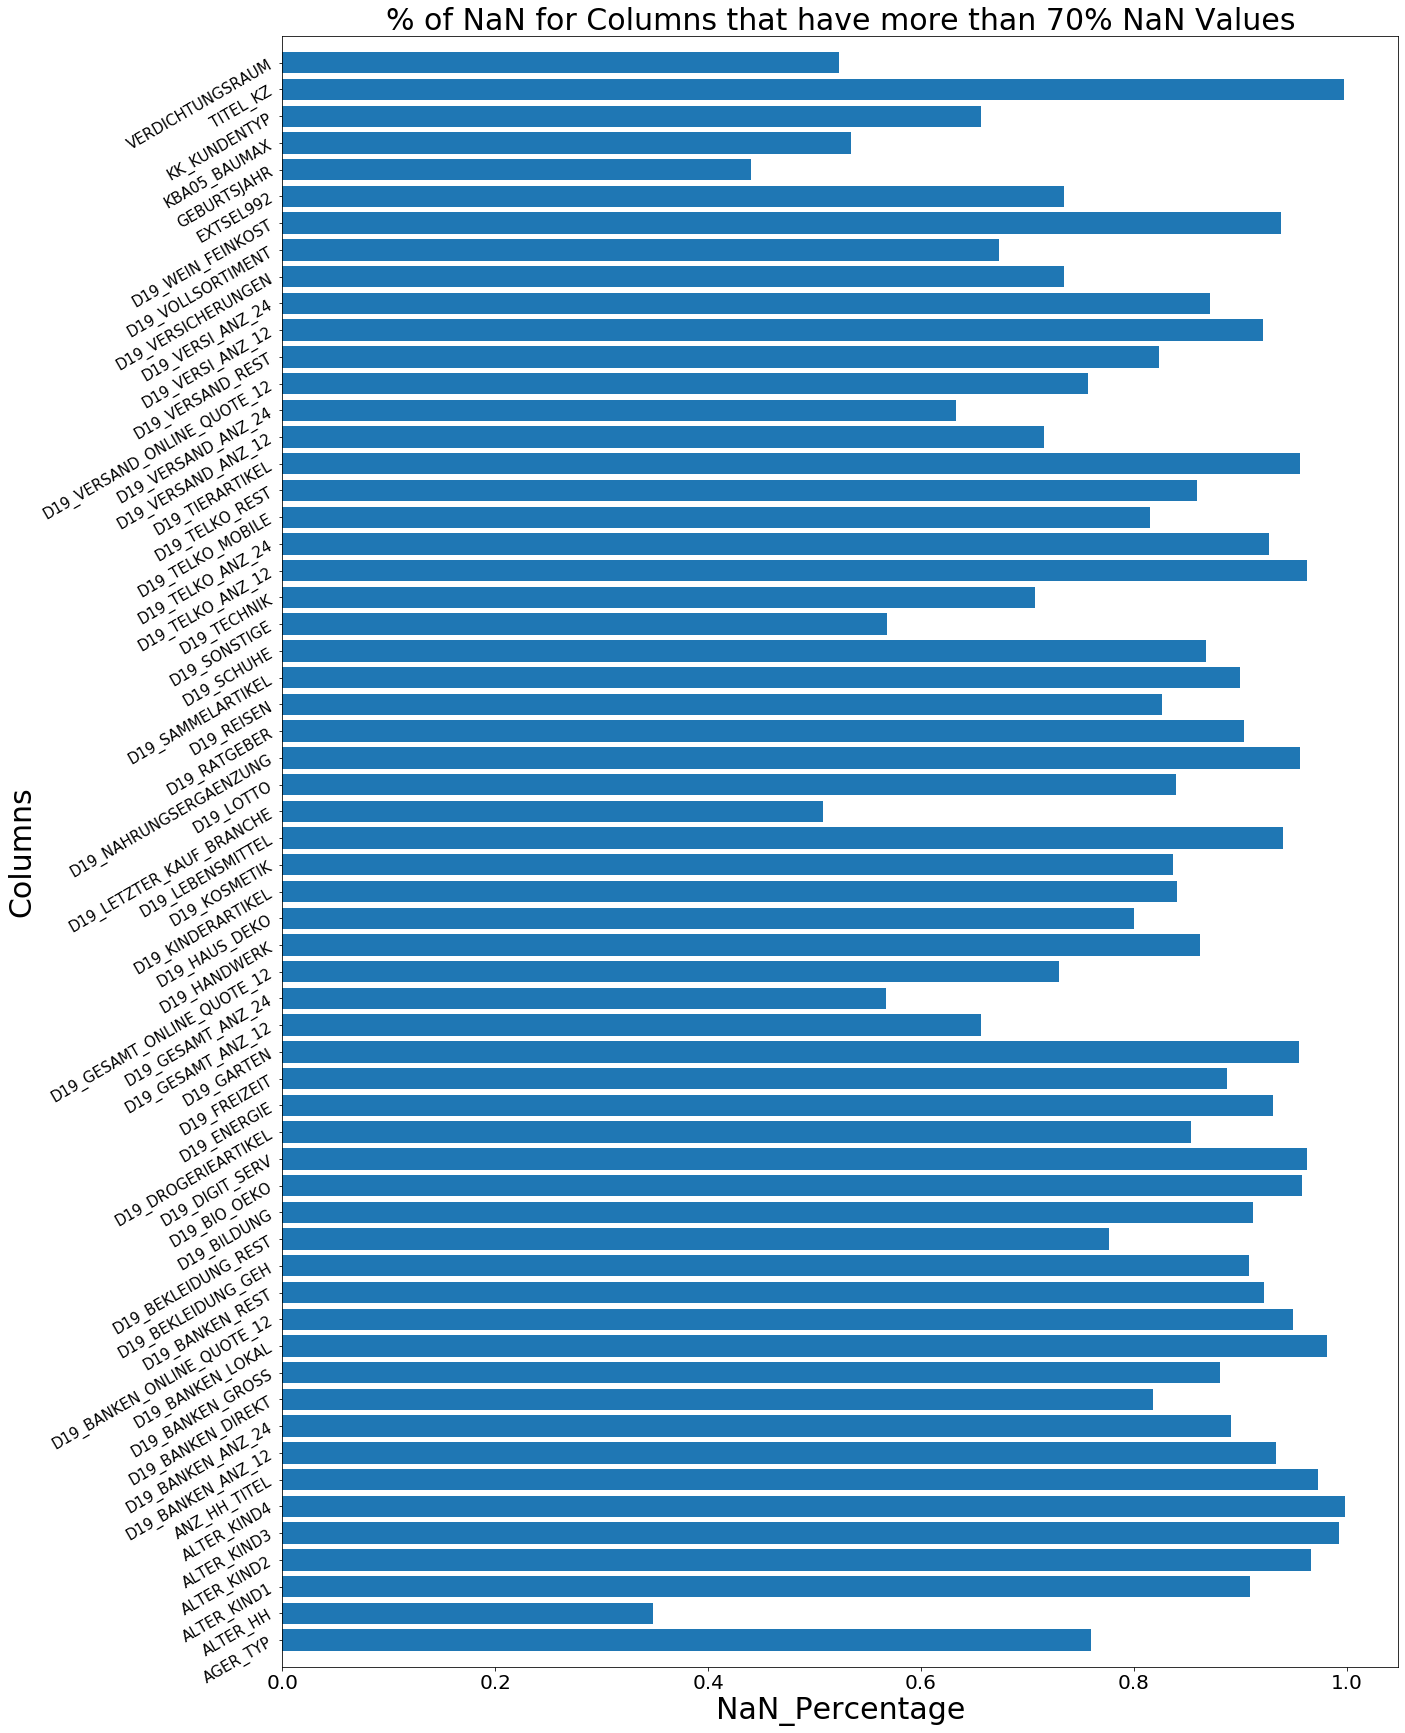

In [684]:
# Plotting the graph of the percentage of values that are NaN in each of the 60 columns
Columns = GP_list['Column']
NaN_Percentage = GP_list['NaN_Count']/len(General_Population_NaN)  
plt.figure(figsize=(20, 30))
plt.barh(Columns,NaN_Percentage)
plt.ylim((-1,60))
plt.xlabel('NaN_Percentage', fontsize=30)
plt.ylabel('Columns', fontsize=30)
index = np.arange(len(Columns))
plt.yticks(index, Columns, fontsize=15, rotation=30)
plt.tick_params(axis="x", labelsize=20)
plt.title('% of NaN for Columns that have more than 70% NaN Values',fontsize=30)
plt.show()

In [696]:
def drop_columns_by_threholds(data,threhold,baseline_data):
    """ Identify which columns from the baseline data have less than "threhold" percentage
        of records being not NaN. And then Drop the respective columns in the data.
    
    Attributes:
        data (dataframe) this is the dataset to be processed. 
        threhold: the percentage of records that need to have non NaN per columns in order
                  to keep this column
        baseline_data: this the baseline dataset, used to identify which columns to drop.
    Output: 
        Return the updated datasets with those columns dropped
    """   
    # See how many NaN in each columns 
    Null_columns_threhold_GP = len(baseline_data) * threhold
    # remove columns that have Null values more than threshold
    General_Population_null_columns=baseline_data.columns[baseline_data.isnull().sum(axis=0) > Null_columns_threhold_GP]
    # drop those columns 
    data_excol = data.drop(columns =General_Population_null_columns )
    
    return data_excol

In [1148]:
# Drop those 60 columns from both customer and general population data sets
General_Population_excol=drop_columns_by_threholds(General_Population_NaN,0.3,General_Population_NaN)
Customer_Population_excol = drop_columns_by_threholds(Customer_Population_NaN,0.3,General_Population_NaN)

## Analyze rows with NaN vales
Looks like only 17% of the row have more than 10% of the column being NaN, and see if those two data sets have different distributions across some columns.
Looks like General Population data has less rows that have NaNs than Customer Population data. But this may be due to the demographic nature of the customers of the mail-order company.

### Split the General Population DataSets based the NaN Count Level
I will split the General Population Datasets into General_Population_RowNaN_High and General_Population_RowNaN_Low data sets and analyse if the distributions among the columns are different.

In [731]:
Null_row_threhold = len(General_Population_excol.columns) * 0.1 # setting the threhold to be 10% of all columns
# Rows with more than 10% columns being NaN in the General Population Data set
General_Population_RowNaN_High = General_Population_excol[General_Population_excol.isnull().sum(axis=1) > Null_row_threhold]
General_Population_RowNaN_Low = General_Population_excol[General_Population_excol.isnull().sum(axis=1) <= Null_row_threhold]

# Rows with more than 10% columns being NaN in the Customer Population Data set
Customer_population_RowNaN_High = Customer_Population_excol[Customer_Population_excol.isnull().sum(axis=1) > Null_row_threhold]
Customer_population_RowNaN_Low = Customer_Population_excol[Customer_Population_excol.isnull().sum(axis=1) <= Null_row_threhold]

print('General Population:{}'.format(len(General_Population_RowNaN_High)/len(General_Population_excol)))
print('Customer Population:{}'.format(len(Customer_population_RowNaN_High)/len(Customer_Population_excol)))

General Population:0.17281235518462873
Customer Population:0.29955335712645836


In [732]:
General_Population_RowNaN_High.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
11,645169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
12,612558,5.0,14.0,1.0,0.0,2.0,1.0,0.0,3.0,2.0,...,4.0,3.0,5.0,3.0,6.0,4.0,3.0,1.0,1.0,3.0
13,612561,8.0,20.0,2.0,0.0,1.0,2.0,0.0,3.0,7.0,...,NaN,3.0,6.0,8.0,6.0,3.0,5.0,5.0,2.0,1.0
14,612565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,3.0


In [879]:
def value_count_column(data_high,data_low,col):
    """ Identify which columns from the baseline data have less than "threhold" percentage
        of records being not NaN. And then Drop the respective columns in the data.
    
    Attributes:
        data_high (dataframe) this is the dataset with high number of NaN columns
        data_low (dataframe) this is the dataset with low number of NaN columns
        col: Name of the column to be compared
    Output: 
        A graph which shows the number of NaN Count per Column 
    """      
    high_count = data_high[col].value_counts()
    low_count = data_low[col].value_counts()

    # Plotting the graph of the percentage of values that are NaN in each of the 60 columns
    Column = high_count.index.ravel().astype('str').tolist()
    Count_high = high_count.ravel().tolist()
    Count_low = low_count.ravel().tolist()

    width = 0.8  # the width of the bars
   
    fig, ax = plt.subplots()
    ax.bar(Column, Count_high, width,  label='High_NaN')
    ax.bar(Column, Count_low, width,  bottom=Count_high,
    label='Low_NaN')
    fig.set_dpi(100)
    ax.set_ylabel('Number of Record Count')
    ax.set_xlabel('Categories of the {}'.format(col))
    ax.set_title('Number of Records per High_NaN and Low_NaN Data Sets')
    ax.legend()
    
    pass

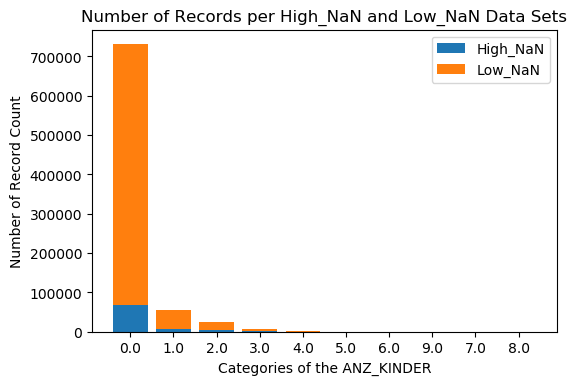

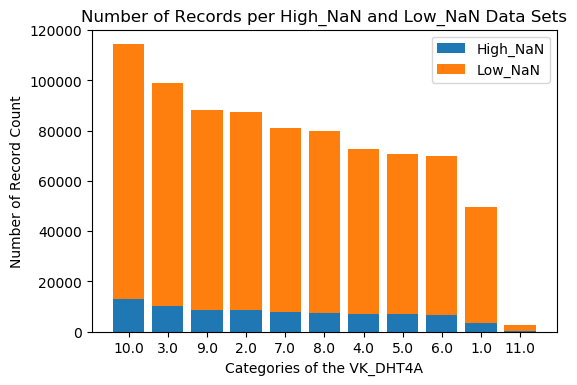

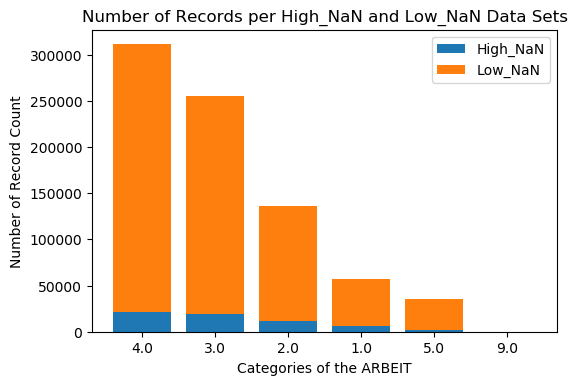

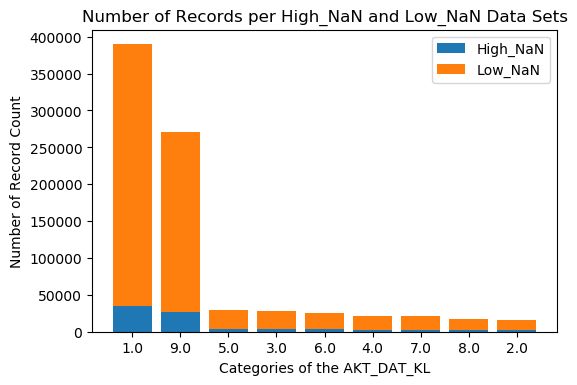

In [893]:
# Randomly select a few fields to see if the distributions of the values between high_NaN_Row and low_NaN_Row Data are different
value_count_column(General_Population_RowNaN_High,General_Population_RowNaN_Low,'ANZ_KINDER')
value_count_column(General_Population_RowNaN_High,General_Population_RowNaN_Low,'VK_DHT4A')
value_count_column(General_Population_RowNaN_High,General_Population_RowNaN_Low,'ARBEIT')
value_count_column(General_Population_RowNaN_High,General_Population_RowNaN_Low,'AKT_DAT_KL')

The distributions for those randomly selected columns are not significantly different between the NaN_High and NaN_Low datasets. Therefore I have decided not to drop those rows with more than 10% of the column values being NaN for now.

## Additional Data Cleansing and Feature Engineering
Many columns have more than 15 unique values, need to analyze whether the columns are numeric or categorical. 
Columns that are categorical but with many classes should be grouped into different buckets, I will group them into different buckets to minimize the number of possible values.

In [894]:
#Identify Columns with more than 15 distinct values 
col_unique_count=pd.DataFrame(columns=['Column','UniqueCount'])
for col in General_Population_excol.columns:
    count = General_Population_excol[col].nunique()
    if count >15:
        list=[[col,count]]
        col_unique_count=col_unique_count.append(pd.DataFrame(list,columns=['Column','UniqueCount']))
    
print(col_unique_count)

                       Column UniqueCount
0                         LNR      891221
0        ALTERSKATEGORIE_FEIN          26
0         ANZ_HAUSHALTE_AKTIV         292
0                ANZ_PERSONEN          30
0  ANZ_STATISTISCHE_HAUSHALTE         268
0              CAMEO_DEU_2015          45
0             CAMEO_INTL_2015          21
0               EINGEFUEGT_AM        5162
0        EINGEZOGENAM_HH_JAHR          37
0            KBA13_ANZAHL_PKW        1261
0         LP_LEBENSPHASE_FEIN          41
0            MIN_GEBAEUDEJAHR          32


In [905]:
top15_category = General_Population_excol.groupby('EINGEZOGENAM_HH_JAHR')['LNR'].count().reset_index(name='count') \
                       .sort_values(['count'], ascending=False) \
                          #.head()
#print(top15_category.isnull()
General_Population_excol['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [926]:
def CategoricalField_Distribution_barchart(data,field):
    
    count_per_category = data[field].value_counts()
    category = count_per_category.index.astype('category')
    count = count_per_category.values.tolist()
    category_length = len(category)    
    plt.figure(figsize=(20, 5))
    plt.bar(category,count)
    plt.xlim((-0.5,category_length))
    plt.xlabel('{}'.format(field), fontsize=20)
    plt.ylabel('Count Per Category', fontsize=20)
    index = np.arange(len(category))
    plt.xticks(index, category, fontsize=15, rotation=30)
    plt.title('Category Distribution of {}'.format(field), fontsize=20)
    
    return plt.show()

In [1149]:
# Drop unwanted field due to duplication of data and unknown meaning of the field
def drop_unwanted_field(data):
    
    bins = [0,15,25,35,45,55,100]
    labels=['Wealthy','Prosperous','Comfortable','Less Affluent','Poorer','Others']
    #labels=['1','2','3','4','5','0']
    data['CAMEO_INTL_2015_new'] = pd.cut(data['CAMEO_INTL_2015'], bins=bins, labels=labels)
    
    unwanted_field = ['ANZ_TITEL','CAMEO_DEU_2015','EINGEZOGENAM_HH_JAHR','MIN_GEBAEUDEJAHR','LP_LEBENSPHASE_FEIN','ALTERSKATEGORIE_FEIN','EINGEFUEGT_AM','CAMEO_INTL_2015','LNR']
    data_new = data.drop(columns = unwanted_field)
    
    return data_new

In [1150]:
# Execute drop_unwanted_field function to both General and Customer Population Data Sets
General_Population_excol = drop_unwanted_field(General_Population_excol)
Customer_Population_excol = drop_unwanted_field(Customer_Population_excol)


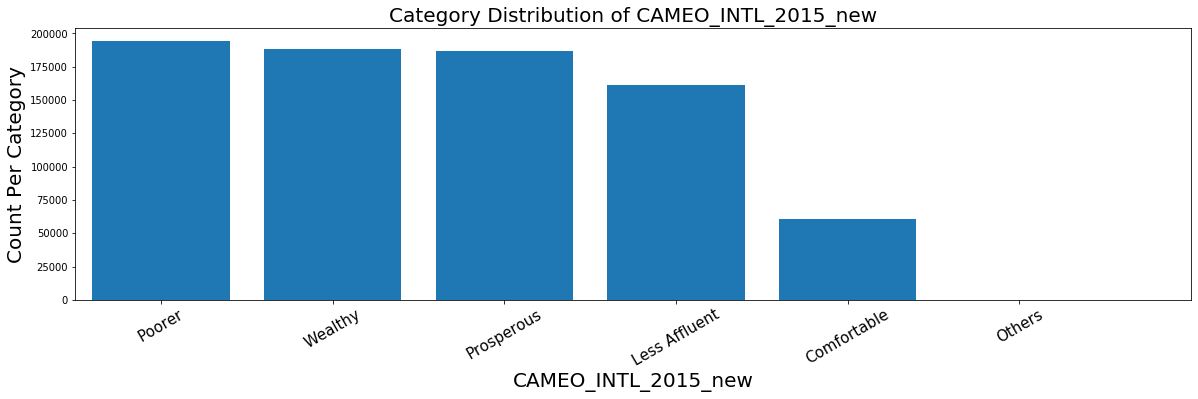

In [941]:
# See values distributions in the CAMEO_INTL_2015_new field 
CategoricalField_Distribution_barchart(General_Population_excol,'CAMEO_INTL_2015_new')

## Data Imputation & Column Data Type Alignment (Dealing with NaN Values)
This is the approach taken: 
1. For binary data column: I will replace Nan with most frequent value
2. For numerical data: I will replace NaN with median value in the column
3. For Categorical data column: Nan values will be NULL as default. 

In [942]:
def data_imputation(data):
    """ Data imputation: convert NaN values in each column into a default values based
        on the data type of the columns 
    
    Attributes:
        data (dataframe) this is the dataset to be processed.
    Output: 
        return the updated dataframe
    """        
    
    numeric_val_fields = ['ANZ_HAUSHALTE_AKTIV','ANZ_PERSONEN','KBA13_ANZAHL_PKW','ANZ_STATISTISCHE_HAUSHALTE','ANZ_KINDER']
    binary_column =['DSL_FLAG', 'GREEN_AVANTGARDE','HH_DELTA_FLAG', 'KBA05_SEG6','KONSUMZELLE','OST_WEST_KZ','SOHO_KZ', 'UNGLEICHENN_FLAG', 'VERS_TYP', 'ANREDE_KZ']
    
    for col in data.columns:
        if col in numeric_val_fields:      
        # Data imputation for numeric fields 
            data[col]= data[col].astype('float64')
            data[col] = data[col].fillna(data[col].median())
        elif col in binary_column:
        # Data imputation for binary fields
            mode = data[col].mode().ravel()[0]
            data[col] = data[col].fillna(mode)    
        else:     
            data[col]= data[col].astype('category').cat.add_categories('NULL').fillna('NULL')
    
    
    return data
    
    

In [1151]:
# Conduct Data Imputation to both General and Customer Population Data Set
General_Population_imputed = data_imputation(General_Population_excol)
Customer_Population_imputed = data_imputation(Customer_Population_excol)

In [1152]:
del General_Population_excol
del Customer_Population_excol

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Before going into principle component analysis, we need to standardize and scale all of the columns. This will ensure that principal component vectors are not impacted by the  differences in scale for every columns in the datasets.

In [946]:
def Standardize_Scaling_col(data):
    """ Encode all categorical columns values into integer
        standardize scaling all values in the data
    
    Attributes:
        data (dataframe) this is the dataset to be processed.
    Output: 
        return the updated dataframe
    """      

    # Define the columsn into different sets based on data types
    numeric_val_fields = ['ANZ_HAUSHALTE_AKTIV','ANZ_PERSONEN','KBA13_ANZAHL_PKW','ANZ_STATISTISCHE_HAUSHALTE','ANZ_KINDER']
    binary_column =['DSL_FLAG', 'GREEN_AVANTGARDE','HH_DELTA_FLAG', 'KBA05_SEG6','KONSUMZELLE','OST_WEST_KZ','SOHO_KZ', 'UNGLEICHENN_FLAG', 'VERS_TYP', 'ANREDE_KZ']
    category_column = [x for x in data.columns if x not in numeric_val_fields + binary_column]

    cat_encode =LabelEncoder() # Need to encode categorical fields into integers  
    scaler = StandardScaler() # Need to scale all fields
      
    # Need to encode all categorical columns first
    for col in category_column+binary_column:
        data[col] = data[col].astype('str')
        data[col] = cat_encode.fit_transform(data[col]) 

    # Next we will do standard scaling for all columns
    data = scaler.fit_transform(data) 
    # data[numeric_val_fields] = scaler.fit_transform(data[numeric_val_fields])    
    # loop through all of the categorical & binary columns in the data set to Standardize
    
    return data

In [1180]:
# Standardize and Scale the datasets 
GP_Standardize = Standardize_Scaling_col(General_Population_imputed)
CP_Standardize = Standardize_Scaling_col(Customer_Population_imputed)

In [1154]:
# Create the Principle Component Model with undefined number of Components
pca_model = PCA()
# fit PCA to general population data
GP_PCA = pca_model.fit_transform(GP_Standardize)

In [991]:
def PCA_Component_Variance(pca):
    '''
    Creates a table that shows the explained variance for each components
    as well as the cumulative explained variance
    
    INPUT: pca - the result of a pca model 
            
    OUTPUT:
            the data of explained variance of the pca model
            
    '''
    list = []
    for i in range(len(pca.explained_variance_ratio_)):
        a = [i,pca.explained_variance_ratio_[i]]
        list.append(a)    
    Data = pd.DataFrame(list,columns=['Component','Variance%'])
    Data['Cumulative_Variance']= Data['Variance%'].cumsum()
    
    return Data

In [1155]:
PCA_Component_Variance(pca_model).head(115)
#del pca_model

,Component,Variance%,Cumulative_Variance
0,0,0.326088,0.326088
1,1,0.056265,0.382353
2,2,0.041740,0.424093
3,3,0.033211,0.457304
4,4,0.031039,0.488343
...,...,...,...
110,110,0.001434,0.895623
111,111,0.001401,0.897024
112,112,0.001391,0.898415
113,113,0.001357,0.899772


In [1156]:
# looks like  starting from n_component= 115 is good enough 
pca_model2 = PCA(n_components=115)
# fit PCA to general population data
GP_PCA_2 = pca_model2.fit_transform(GP_Standardize)

In [985]:
def Scree_Plot_PCA(pca):
    '''
    Creates a scree plot graph for a particular principal component model
    
    INPUT: pca - the result of a pca model 
            
    OUTPUT:
            the scree plot graph
            
    '''
    num_components = len(pca.explained_variance_ratio_)
    index = np.arange(num_components)
    variance = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    plot = plt.subplot()
    cumvariance = np.cumsum(variance)
    plot.bar(index, variance)
    plot.plot(index, cumvariance)
    plot.xaxis.set_tick_params(width=1,labelsize=20)
    plot.yaxis.set_tick_params(width=2, length=10,labelsize=20)
 
    plot.set_xlabel("Number of Principal Components",fontsize = 20.0)
    plot.set_ylabel("Variance Explained (%)", fontsize = 20.0)
    plt.title('Explained Variance Per Principal Component',fontsize=30)
    
    pass

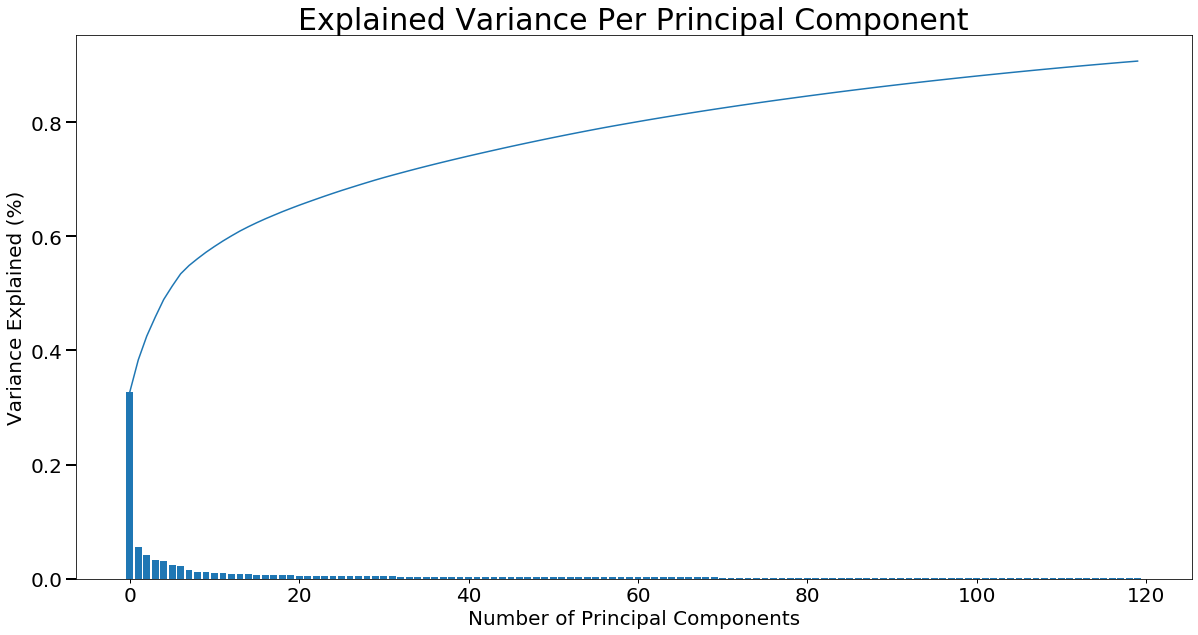

In [1002]:
# plot the scree plot 
Scree_Plot_PCA(pca_model2)

In [1160]:
# Display the top 5 and last 5 features per PCA Components
features = pd.DataFrame(General_Population_imputed.columns.values)
components = pd.DataFrame(pca_model2.components_[1])
frames = [features, components]
result = pd.concat(frames,axis=1)
result.columns=['Feature','Weight']
result.sort_values(by=['Weight'])

,Feature,Weight
244,LP_STATUS_GROB,-0.169311
41,FINANZ_MINIMALIST,-0.168849
246,MOBI_REGIO,-0.134795
61,KBA05_ANTG1,-0.132427
72,KBA05_GBZ,-0.130950
...,...,...
38,EWDICHTE,0.132513
131,KBA13_BAUMAX,0.133099
54,HH_EINKOMMEN_SCORE,0.133405
126,KBA13_ANTG3,0.143144


In [1183]:
# Apply the same PCA Transformation to Customer Population Data 
CP_PCA_2 = pca_model2.transform(CP_Standardize)

## K Mean Clustering 
Apply Unsupervised Clustering Technique Kmean Clustering, to understand what are the segmentation within in the whole and General Population. And then Compare it to the customer population data

In [1003]:
def get_kmeans_score(data, num_centroid):
    '''
    Calculate the kmeans SSE Score for a given number of centroid
    INPUT:
        data - the data that you want to fit on 
        num_centroid - the number of centroids (K value)
    OUTPUT:
        score - the SSE score 
    '''
    # instantiate kmeans
    kmeans = KMeans(n_clusters=num_centroid)

    # fit the kmeans model to your data 
    KMean_model = kmeans.fit(data)
    
    # calculate the score for the fitted Kmeans Model 
    score = np.abs(KMean_model.score(data))
    
    return score

In [1161]:
# Loop through a selected range of cluster/centroids and obtain the SSE score in a list
scores = []
cluster = range(1,30,3)

for c in cluster:
    scores.append(get_kmeans_score(GP_PCA_2, cluster))

Text(0.5, 1.0, 'SSE vs. K')

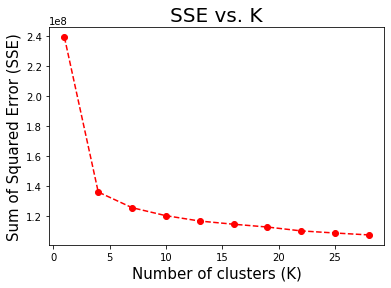

In [1172]:
# Plot the elbow method graph 
plt.plot(centers, scores, linestyle='--', marker='o', color='r');
plt.xlabel('Number of clusters (K)',fontsize=15);
plt.ylabel('Sum of Squared Error (SSE)',fontsize=15);
plt.title('SSE vs. K',fontsize=20)

Looks like in this case picking a K=13 is appropriate as the decrease in SSE after 13 is very minimal.

### Compare the Customer Population and General Population Data for each of the 13 clusters
The next step is to look at the distributions of Customer and General Population data in each of the 13 clusters.

In [1184]:
# Fit Kmean model 
Kmean_model = get_kmeans_score(GP_PCA_2,13)
#instantiate kmeans with cluster number bieng 13
kmeans = KMeans(n_clusters=13)

# Then fit the model to General Population data
Kmean_model = kmeans.fit(GP_PCA_2)
# Predict which cluster each individual should be in for both data sets
GP_ClusterPrediction = kmeans.predict(GP_PCA_2)
CP_ClusterPrediction = kmeans.predict(CP_PCA_2)

I would like to plot the percentage distribution of clusters for both data sets and compare the differences

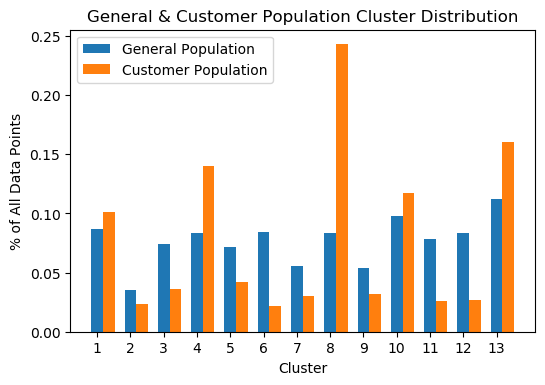

In [1209]:
# Count the number of records in each cluster
Cluster_GP, Counts_GP = np.unique(GP_ClusterPrediction, return_counts=True) 
Cluster_CP, Counts_CP = np.unique(CP_ClusterPrediction, return_counts=True)

GP_Length = len(GP_ClusterPrediction) # number of data points in the General Population Data
CP_Length = len(CP_ClusterPrediction) # number of data points in the Customer Population Data


index = np.arange(13) # number of clusters
bar_width = 0.35

fig, ax = plt.subplots()
General_Population = ax.bar(index, Counts_GP/GP_Length, bar_width,
                label="General Population")

Customer_Population = ax.bar(index+bar_width, Counts_CP/CP_Length,
                 bar_width, label="Customer Population")

ax.set_xlabel('Cluster')
ax.set_ylabel('% of All Data Points')
ax.set_title('General & Customer Population Cluster Distribution')
ax.set_xticks(index )
ax.set_xticklabels(["1", "2", "3", "4", "5","6", "7", "8", "9", "10","11", "12", "13"])
ax.legend()
fig.set_dpi(100)
plt.show()

In [1229]:
weights = kmeans.cluster_centers_[7]
len(weights)
#components = range(len(weights))
#r=range(len(weights))
components=[*range(len(weights))]
cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
cluster_expl.sort_values("Weights", ascending=False, inplace=True)
cluster_expl

,Weights,Component
0,27.417256,0
1,1.277379,1
2,0.767279,2
10,0.705727,10
13,0.684621,13
...,...,...
8,-0.741997,8
11,-0.889024,11
5,-1.037544,5
12,-1.082641,12


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1373]:
mailout_train = pd.read_csv('C:/Users/ruoyu.zhao/Anaconda3/ML/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\ruoyu.zhao\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


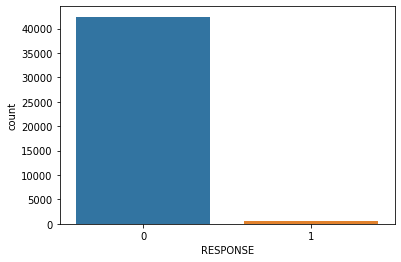

In [1319]:
# We have a highly imbalance dataset
sns.countplot("RESPONSE", data=mailout_train)

# Dealing with imbalance Dataset

In [1386]:
# Dealing with class imbalance dataset : Resampling

# Split Train data into 2 data sets based on Repsonse 
Yes_Customer = mailout_train[mailout_train['RESPONSE']==1] # Minority class
No_Customer = mailout_train[mailout_train['RESPONSE']==0] # Majority clss
# Resampling the Yes_Customer Data set to match up with the number of records in No_Customer 
Yes_Customer_upsampled = resample(Yes_Customer, 
                                  replace=True,     # sample with replacement
                                  n_samples=42430,    # to match majority class
                                  random_state=1) # reproducible results
# Combine the Yes_Customer_upsampled and No_Customer data set back again 
train_balanced = pd.concat([No_Customer, Yes_Customer_upsampled])

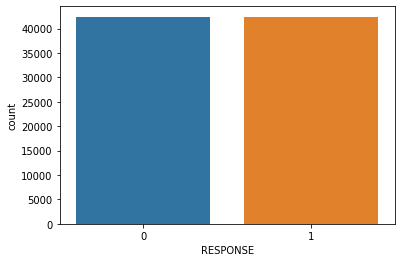

In [1389]:
# We have a highly imbalance dataset
sns.countplot("RESPONSE", data=train_balanced)

### Clean and split the training data 
Applying the same cleaning process to the training data and 
spliting the data into training and validation sets

In [1441]:
# Apply all the cleaning to training data set: 
train_label = train_balanced['RESPONSE'].astype('int') # set the target variable
LNR = pd.DataFrame(train_balanced['LNR'])
Train_data =train_balanced.drop(columns = 'RESPONSE')
Train_data = column_values_alignment(Train_data)
Train_data = convert_default_into_NaN(Train_data)
Train_data = drop_columns_by_threholds(Train_data,0.3,General_Population_NaN)
Train_data = drop_unwanted_field(Train_data)
#Data imputation 
Train_data = data_imputation(Train_data)
# Columns Standardize
Train_data_standardize = Standardize_Scaling_col(Train_data)
# split the data set into train and validation set
seed = 1  
train_size = 0.7
X_train, X_val, y_train, y_val = train_test_split(Train_data_standardize, train_label, train_size=train_size, random_state=seed)

In [1442]:
Train_data.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_INTL_2015_new
0,0,15.0,0.0,1.0,13.0,2,4,4,1,4,...,6,5,0,5,8,3,2,1,3,0
1,3,1.0,0.0,2.0,1.0,1,4,4,1,1,...,0,5,0,3,8,6,0,1,2,0
2,0,0.0,0.0,0.0,1.0,3,0,1,3,4,...,7,7,3,6,8,2,2,0,3,5
3,0,4.0,0.0,2.0,4.0,3,1,1,1,4,...,9,2,2,5,8,1,2,1,3,5
4,0,53.0,0.0,1.0,44.0,2,3,6,5,4,...,3,5,0,5,8,3,2,0,2,1


## Test the benchmark Model

Setting the benchmark model to be a Linear Regression Model without any hyperparameters tunning.


In [1383]:
# fit data to a linear regression model 
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_val)
print('Validation ROC AUC: {}'.format(roc_auc_score(np.array(y_val), pred)))


Validation ROC AUC: 0.6395966827949958


## Test more Machine Learning Models
The following models would be trained and compared against their performance to the validation data set.

## Logistic Regression Model

In [1400]:
# fit data to a logistic regression model 
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_val)
print('Validation ROC AUC: {}'.format(roc_auc_score(np.array(y_val), pred)))

C:\Users\ruoyu.zhao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Validation ROC AUC: 0.7291567866842354


## XGboost Model

In [1408]:
# Grid Search and cross validation for Xgboost Classifer
xgb_Tuning = {'n_estimators':range(50,150,50),'learning_rate':[0.1,0.5,1.],'gamma':[0.1,0.5,0.8],"max_depth": [10,20,30]}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic',eval_metric='auc',random_state=1), 
param_grid = xgb_Tuning, scoring='roc_auc',n_jobs=-1,iid=False, cv=5, verbose=2)
gsearch1.fit(X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 75.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='auc',
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'gamma': [0.1, 0.5, 0.8],
                         'learning_rate': [0.1, 0.5, 1.0],
    

In [1409]:
# find the best parameters
gsearch1.best_params_

{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 100}

In [1411]:
# instantiate the XGBoost model with the best parameters
xgboost = xgb.XGBClassifier(objective='binary:logistic',eval_metric='auc',random_state=1,n_estimators=100,learning_rate=0.1, gamma=0.1,max_depth=30 )
xgboost.fit(X_train, y_train)
# predict using the validation data set
pred = xgboost.predict(X_val)
# get the ROC AUC for the validation data set 
roc_auc_score(y_val, pred) 

0.9476535449555935

## Adaboost Classifier

In [1395]:
# Grid Search and cross validation for Adaboost Classifier
Ada_Tuning = {'n_estimators':range(50,200,50),'learning_rate':[0.01,0.1,0.5,0.9,1.]}
gsearch2 = GridSearchCV(estimator = AdaBoostClassifier(random_state=0), 
param_grid = Ada_Tuning, scoring='roc_auc',n_jobs=-1,iid=False, cv=5, verbose=2)
gsearch2.fit(X_train, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 15.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=0),
             iid=False, n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 0.9, 1.0],
                         'n_estimators': range(50, 200, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=2)

In [1397]:
# find the best parameters for n_estimators and learning rate
gsearch2.best_params_

{'learning_rate': 1.0, 'n_estimators': 150}

In [1399]:
# instantiate the AdaBoost model with the best parameters
adaboost = AdaBoostClassifier(n_estimators=150, learning_rate=1, random_state=0)
adaboost.fit(X_train, y_train)
# predict using the validation data set
pred = adaboost.predict(X_val)
# get the ROC AUC for the validation data set 
roc_auc_score(y_val, pred) 

0.7718377553565314

## Feature Importance Analysis

In [1453]:
# Identify the top 10 most important features for XGBoost
Feature_importance_values = pd.DataFrame(xgboost.feature_importances_)
Feature_Name = pd.DataFrame(Train_data.columns)
Feature_Importance = pd.concat([Feature_Name,Feature_importance_values],axis=1)
Feature_Importance.columns=['Feature Name','Importance Values']
Feature_Importance.sort_values('Importance Values', ascending = False).reset_index(drop = True).head(10)

,Feature Name,Importance Values
0,D19_SOZIALES,0.097584
1,KBA13_KW_61_120,0.041761
2,VERS_TYP,0.013284
3,D19_BANKEN_OFFLINE_DATUM,0.013075
4,KBA05_KRSAQUOT,0.009622
5,KBA05_KRSOBER,0.008321
6,D19_KONSUMTYP,0.007816
7,KBA13_KRSSEG_VAN,0.007565
8,PLZ8_ANTG1,0.007511
9,KBA13_KW_90,0.007241


In [1452]:
# Identify the top 10 most important features for Adaboost
Feature_importance_values = pd.DataFrame(adaboost.feature_importances_)
Feature_Name = pd.DataFrame(Train_data.columns)
Feature_Importance = pd.concat([Feature_Name,Feature_importance_values],axis=1)
Feature_Importance.columns=['Feature Name','Importance Values']
Feature_Importance.sort_values('Importance Values', ascending = False).reset_index(drop = True).head(10)

,Feature Name,Importance Values
0,D19_SOZIALES,0.053333
1,KBA13_ANZAHL_PKW,0.040000
2,ANZ_STATISTISCHE_HAUSHALTE,0.026667
3,ANZ_PERSONEN,0.020000
4,KBA05_KW2,0.020000
5,KBA13_ALTERHALTER_30,0.020000
6,GFK_URLAUBERTYP,0.013333
7,ANZ_HAUSHALTE_AKTIV,0.013333
8,UMFELD_JUNG,0.013333
9,STRUKTURTYP,0.013333


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [1412]:
# Read in the test data set for Kaggle
mailout_test = pd.read_csv('C:/Users/ruoyu.zhao/Anaconda3/ML/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\ruoyu.zhao\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1422]:
# Apply all the cleaning to test data set: 
LNR = pd.DataFrame(mailout_test['LNR'])
Test_data = column_values_alignment(mailout_test)
Test_data = convert_default_into_NaN(Test_data)
Test_data = drop_columns_by_threholds(Test_data,0.3,General_Population_NaN)
Test_data = drop_unwanted_field(Test_data)
#Data imputation 
Test_data = data_imputation(Test_data)
# Columns Standardize
Test_data = Standardize_Scaling_col(Test_data)

In [1427]:
# predict test data response using xgboost classification model
xgb_predictions = xgboost.predict_proba(Test_data)

In [1428]:
# predict test data response using adaboost classification model
ada_predictions = adaboost.predict_proba(Test_data)

In [1429]:
#Convert the prediction results into dataframe
xgb_predict_output = pd.DataFrame(xgb_predictions,columns=['NO','RESPONSE'])
ada_predict_output = pd.DataFrame(ada_predictions,columns=['NO','RESPONSE'])

In [1431]:
#Join LNR field with the repsonse field
Submit_Result_ada = LNR.join(ada_predict_output['RESPONSE'])
Submit_Result_xgb = LNR.join(xgb_predict_output['RESPONSE'])

In [1435]:
#check the table sctructure
Submit_Result_ada.head()

,LNR,RESPONSE
0,1754,0.501294
1,1770,0.501306
2,1465,0.496178
3,1470,0.495364
4,1478,0.495456


In [1433]:
# Save the results into csv
Submit_Result_ada.to_csv(r'C:/Users/ruoyu.zhao/Anaconda3/ML/Submission_ada1.csv',index=False)
Submit_Result_xgb.to_csv(r'C:/Users/ruoyu.zhao/Anaconda3/ML/Submission_xgb.csv',index=False)